In [ ]:
!pip install transformers[torch] sentence-transformers requests pandas matplotlib reportlab tqdm scikit-learn torch

In [ ]:
# %%
# Instale as dependências (descomente e rode se necessário)
!pip install transformers[torch] sentence-transformers requests pandas matplotlib reportlab tqdm scikit-learn torch

# %%
# Imports & setup
import os
import time
import json
import re
from pathlib import Path
from statistics import mean
from typing import List, Dict, Any, Optional

import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image as RLImage
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

GITHUB_REPO = "2noise/ChatTTS"
BRANCH = "main"
RAW_BASE = "https://raw.githubusercontent.com"

# Output directory
OUTPUT_DIR = Path("chattts_analysis_output")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Modelos de Análise ---
MODEL_ZERO_SHOT = "facebook/bart-large-mnli" # Para classificação de arquitetura
MODEL_TOKEN = "dslim/bert-base-NER"          # Para extração de entidades (NER)
MODEL_TEXT_EMBED = "sentence-transformers/all-MiniLM-L6-v2" # Para TODOS embeddings (Docs e Código)

CANDIDATE_LABELS = [
    "MVC", "Layered", "Microservices", "Event-Driven", "Pipe-and-Filter", "Monolithic", "Library", "CLI", "Web Application"
]

CHUNK_SIZE = 1000

def fetch_github_raw(repo: str, path: str, branch: str = "main") -> Optional[str]:
    url = f"{RAW_BASE}/{repo}/{branch}/{path}"
    r = requests.get(url)
    if r.status_code == 200:
        return r.text
    return None

def gather_repo_texts(repo: str, branch: str = BRANCH, max_files: int = 50) -> Dict[str,str]:
    files = {}
    for candidate in ["README.md", "readme.md", "README.MD", "README"]:
        t = fetch_github_raw(repo, candidate, branch)
        if t:
            files[candidate] = t
            break
    for candidate in ["requirements.txt", "pyproject.toml", "setup.py", "package.json"]:
        t = fetch_github_raw(repo, candidate, branch)
        if t:
            files[candidate] = t
    try:
        api = f"https://api.github.com/repos/{repo}/git/trees/{branch}?recursive=1"
        r = requests.get(api, headers={"Accept": "application/vnd.github.v3+json"})
        if r.status_code == 200:
            tree = r.json().get("tree", [])
            count = 0
            for entry in tree:
                path = entry.get("path","")
                if path.endswith(".py") or path.endswith(".js") or path.endswith(".ts"):
                    raw = fetch_github_raw(repo, path, branch)
                    if raw:
                        files[path] = raw
                        count += 1
                        if count >= max_files:
                            break
    except Exception as e:
        print("Warning listing repo tree:", e)
    return files

def normalize_text(text: str) -> str:
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def chunk_text(text: str, max_chars: int = CHUNK_SIZE) -> List[str]:
    text = normalize_text(text)
    paragraphs = text.split("\n\n")
    chunks = []
    cur = []
    cur_len = 0
    for p in paragraphs:
        if cur_len + len(p) + 2 <= max_chars:
            cur.append(p)
            cur_len += len(p) + 2
        else:
            if cur:
                chunks.append("\n\n".join(cur))
            if len(p) > max_chars:
                for i in range(0, len(p), max_chars):
                    chunks.append(p[i:i+max_chars])
                cur = []
                cur_len = 0
            else:
                cur = [p]
                cur_len = len(p) + 2
    if cur:
        chunks.append("\n\n".join(cur))
    return chunks

print("Loading pipelines and models (this may download weights)...")
device = 0 if torch.cuda.is_available() else -1

# Pipeline 1: Zero-Shot (Arquitetura)
pipe_zero_shot = pipeline("zero-shot-classification", MODEL_ZERO_SHOT, device=device)

# Pipeline 2: NER (Tokens)
pipe_token = pipeline("token-classification", MODEL_TOKEN, aggregation_strategy="simple", device=device)

# Pipeline 3: Embeddings (Similaridade)
# Este único modelo será usado para docs E código.
sbert = SentenceTransformer(MODEL_TEXT_EMBED)

print("Pipelines loaded. Device:", "cuda" if device==0 else "cpu or cpu fallback")

def benchmark_call(func, inputs: List[Any], repeats: int = 3):
    times = []
    n = len(inputs)
    try:
        func(inputs[:1]) # Warm-up
    except Exception:
        pass
    for r in range(repeats):
        t0 = time.time()
        func(inputs)
        t1 = time.time()
        times.append(t1-t0)
    avg_total = mean(times)
    per_item = avg_total / n if n else float("inf")
    throughput = n / avg_total if avg_total>0 else float("inf")
    return {"times": times, "avg_total_s": avg_total, "latency_per_item_s": per_item, "throughput_items_per_s": throughput}

def run_analysis(repo: str = GITHUB_REPO):
    files = gather_repo_texts(repo)
    if not files:
        raise RuntimeError("No files fetched from repo.")
    print(f"Collected {len(files)} files (README + code snippets).")

    records = []
    for path, content in files.items():
        typ = "code" if (path.endswith(".py") or path.endswith(".js") or path.endswith(".ts")) else "doc"
        chunks = chunk_text(content, max_chars=CHUNK_SIZE) if typ=="doc" else [content]
        for i, ch in enumerate(chunks):
            records.append({"path": path, "type": typ, "chunk_index": i, "text": ch[:CHUNK_SIZE*2]})

    df = pd.DataFrame(records)
    print(f"Built dataset with {len(df)} items. Sample:")
    print(df.head())

    doc_indices = df[df["type"]=="doc"].index
    doc_texts = df.loc[doc_indices, "text"].tolist()

    code_indices = df[df["type"]=="code"].index
    code_texts = df.loc[code_indices, "text"].tolist()

    # --- Análise 1: Zero-Shot Classification (Arquitetura) ---
    text_results = []
    if doc_texts:
        for t in tqdm(doc_texts, desc="Zero-shot classification (BART)"):
            try:
                out = pipe_zero_shot(t, CANDIDATE_LABELS)
                text_results.append({"label": out['labels'][0], "score": out['scores'][0]})
            except Exception as e:
                text_results.append({"label": "ERROR", "score": 0.0})
        df.loc[doc_indices, "out_zero_shot"] = pd.Series(text_results, index=doc_indices)

    # --- Análise 2: Token Classification (NER) ---
    ner_results = []
    if doc_texts:
        for t in tqdm(doc_texts, desc="Token-classification (NER)"):
            try:
                out = pipe_token(t)
            except Exception as e:
                out = []
            ner_results.append(out)
        df.loc[doc_indices, "out_ner_dslim"] = pd.Series(ner_results, index=doc_indices)

    # --- Análise 3: Code Embeddings (SBERT) ---
    #  <--- ESTA É A MUDANÇA PRINCIPAL
    code_embeddings = []
    if code_texts:
        print(f"Generating {len(code_texts)} code embeddings using SBERT...")
        # Usamos o SBERT aqui
        code_embeddings = sbert.encode(code_texts, show_progress_bar=True)
        df.loc[code_indices, "code_embedding"] = pd.Series(
            [list(e) for e in code_embeddings],
            index=code_indices
        )

    # --- Análise 4: Document Embeddings (SBERT) ---
    doc_embeddings = []
    if doc_texts:
        print(f"Generating {len(doc_texts)} doc embeddings using SBERT...")
        # E usamos o SBERT aqui também
        doc_embeddings = sbert.encode(doc_texts, show_progress_bar=True)
        df.loc[doc_indices, "doc_embedding"] = pd.Series(
            [list(e) for e in doc_embeddings],
            index=doc_indices
        )

    # --- Análise 5: Similaridade Código <-> Documento ---
    # Agora ambos (code_embeddings e doc_embeddings) terão 384 dimensões
    sim_pairs = []
    if len(code_embeddings) > 0 and len(doc_embeddings) > 0:
        print("Calculating cosine similarity...")
        sims = cosine_similarity(code_embeddings, doc_embeddings) # <-- AGORA FUNCIONA
        for i, row in enumerate(sims):
            best_j = int(row.argmax())
            sim_pairs.append({"code_index": i, "best_doc_index": best_j, "similarity": float(row.max())})
    sims_df = pd.DataFrame(sim_pairs)

    # --- Salvando Resultados ---
    df.to_pickle(OUTPUT_DIR / "analysis_dataframe.pkl")
    if text_results:
        pd.DataFrame(text_results).to_csv(OUTPUT_DIR / "zero_shot_text_results.csv", index=False)
    sims_df.to_csv(OUTPUT_DIR / "code_doc_similarity.csv", index=False)
    print("Saved outputs to", OUTPUT_DIR)

    # --- Benchmarking ---
    sample_docs = doc_texts[:8] if len(doc_texts) >= 1 else [""]
    sample_code = code_texts[:4] if len(code_texts) >= 1 else [""]

    bench_text = benchmark_call(lambda xs: pipe_zero_shot(xs, CANDIDATE_LABELS), sample_docs)
    bench_ner = benchmark_call(lambda xs: pipe_token(xs), sample_docs)
    # <--- MUDANÇA NO BENCHMARK
    bench_code = benchmark_call(lambda xs: sbert.encode(xs), sample_code)
    bench_sbert = benchmark_call(lambda xs: sbert.encode(xs), sample_docs)

    benches = {
        "zero_shot_text": bench_text,
        "dslim_ner": bench_ner,
        "sbert_code_embed": bench_code, # <-- Key atualizada
        "sbert_doc_embed": bench_sbert
    }

    result = {"df": df, "sims_df": sims_df, "benches": benches}
    return result

# %%
# --- Execução Principal ---
results = run_analysis(GITHUB_REPO)
df = results["df"]
benches = results["benches"]

# %%
# --- Plotagem de Benchmarks ---
def save_bench_plots(benches: Dict[str,Any], outdir: Path):
    keys = list(benches.keys())
    latencies = [benches[k]["latency_per_item_s"] if benches[k]["latency_per_item_s"] != float("inf") else 0 for k in keys]
    through = [benches[k]["throughput_items_per_s"] if benches[k]["throughput_items_per_s"] != float("inf") else 0 for k in keys]

    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(keys, latencies)
    ax.set_ylabel("Latency per item (s)")
    ax.set_title("Latency comparison")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    p = outdir / "bench_latency.png"
    fig.savefig(p)
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(keys, through)
    ax.set_ylabel("Throughput (items/s)")
    ax.set_title("Throughput comparison")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    p2 = outdir / "bench_throughput.png"
    fig.savefig(p2)
    plt.close(fig)
    print("Saved bench plots to", outdir)

save_bench_plots(benches, OUTPUT_DIR)

print("\nAnálise concluída e salva em:", OUTPUT_DIR)

Loading pipelines and models (this may download weights)...


Device set to use cpu
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Pipelines loaded. Device: cpu or cpu fallback
Collected 52 files (README + code snippets).
Built dataset with 65 items. Sample:
        path type  chunk_index  \
0  README.md  doc            0   
1  README.md  doc            1   
2  README.md  doc            2   
3  README.md  doc            3   
4  README.md  doc            4   

                                                text  
0  <div align="center">\n\n<a href="https://trend...  
1  [![Huggingface](https://img.shields.io/badge/🤗...  
2  ChatTTS is a text-to-speech model designed spe...  
3  - The main model is trained with Chinese and E...  
4  The model is published under `CC BY-NC 4.0` li...  


Token-classification (NER): 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]

Generating 50 code embeddings using SBERT...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Generating 15 doc embeddings using SBERT...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating cosine similarity...
Saved outputs to chattts_analysis_output
Saved bench plots to chattts_analysis_output

Análise concluída e salva em: chattts_analysis_output


In [ ]:
# %%
# Imports & setup
import os
import time
import json
import re
import subprocess
import shutil
from pathlib import Path
from statistics import mean
from typing import List, Dict, Any, Optional
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification, AutoModelForSequenceClassification
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image as RLImage
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

# =============================================================================
# CONFIGURAÇÕES DO PROJETO
# =============================================================================
GITHUB_REPO = "2noise/ChatTTS"
REPO_NAME = GITHUB_REPO.split("/")[-1]
BRANCH = "main"
PROJECT_NAME = "ChatTTS"
TEAM_MEMBERS = ["Seu_Nome", "Outro_Membro", "Terceiro_Membro"]

# Output directories
OUTPUT_DIR = Path("chattts_analysis")
OUTPUT_DIR.mkdir(exist_ok=True)
REPO_DIR = OUTPUT_DIR / "cloned_repo"
REPO_DIR.mkdir(exist_ok=True)

# =============================================================================
# MODELOS DE ANÁLISE
# =============================================================================
MODEL_SENTIMENT = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
MODEL_NER = "dslim/bert-base-NER"
MODEL_CODE = "microsoft/codebert-base"

ARCHITECTURAL_PATTERNS = [
    "MVC (Model-View-Controller)",
    "Layered Architecture",
    "Microservices Architecture",
    "Event-Driven Architecture",
    "Pipe-and-Filter Architecture",
    "Monolithic Architecture",
    "Client-Server Architecture",
    "Service-Oriented Architecture (SOA)",
    "Repository Architecture",
    "Plugin Architecture"
]

ARCHITECTURAL_KEYWORDS = [
    'service', 'model', 'view', 'controller', 'microservice', 'api', 'endpoint',
    'database', 'client', 'server', 'event', 'message', 'queue', 'broker',
    'layer', 'tier', 'module', 'component', 'interface', 'repository',
    'factory', 'adapter', 'decorator', 'observer', 'strategy', 'singleton'
]

CHUNK_SIZE = 1000

# =============================================================================
# FUNÇÕES AUXILIARES
# =============================================================================
def json_serializable(obj):
    """Converte objetos para formatos serializáveis em JSON"""
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict()
    elif isinstance(obj, pd.Series):
        return obj.tolist()
    elif hasattr(obj, '__dict__'):
        return obj.__dict__
    else:
        return str(obj)

def clone_github_repo(repo_url: str, target_dir: Path) -> bool:
    """Clona o repositório GitHub localmente"""
    try:
        print(f"📥 Clonando repositório: {repo_url}")
        if not repo_url.startswith('https://'):
            repo_url = f'https://github.com/{repo_url}.git'

        # Remove diretório existente
        if target_dir.exists():
            shutil.rmtree(target_dir)

        result = subprocess.run(
            ['git', 'clone', '--depth', '1', repo_url, str(target_dir)],
            capture_output=True,
            text=True,
            timeout=300
        )

        if result.returncode == 0:
            print(f"✅ Repositório clonado em: {target_dir}")
            return True
        else:
            print(f"❌ Erro ao clonar: {result.stderr}")
            return False

    except Exception as e:
        print(f"❌ Erro ao clonar: {e}")
        return False

def gather_local_files(repo_dir: Path, max_files: int = 100) -> Dict[str, str]:
    """Coleta arquivos do repositório clonado"""
    files = {}

    code_patterns = ['*.py', '*.js', '*.ts', '*.java', '*.cpp', '*.c', '*.h']
    doc_patterns = ['README*', '*.md', '*.txt', '*.rst']
    config_patterns = ['requirements*', 'setup.py', 'pyproject.toml', 'package.json',
                      'Dockerfile', 'docker-compose.yml', '.gitignore']

    try:
        # Documentação
        for pattern in doc_patterns:
            for file_path in repo_dir.rglob(pattern):
                if file_path.is_file() and file_path.stat().st_size < 1_000_000:  # < 1MB
                    try:
                        content = file_path.read_text(encoding='utf-8', errors='ignore')
                        relative_path = file_path.relative_to(repo_dir)
                        files[str(relative_path)] = content
                        print(f"✅ Doc: {relative_path}")
                    except Exception as e:
                        print(f"⚠️  Erro ao ler {file_path}: {e}")

        # Configuração
        for pattern in config_patterns:
            for file_path in repo_dir.rglob(pattern):
                if file_path.is_file() and str(file_path.relative_to(repo_dir)) not in files:
                    try:
                        content = file_path.read_text(encoding='utf-8', errors='ignore')
                        relative_path = file_path.relative_to(repo_dir)
                        files[str(relative_path)] = content
                        print(f"✅ Config: {relative_path}")
                    except Exception as e:
                        print(f"⚠️  Erro ao ler {file_path}: {e}")

        # Código
        file_count = 0
        for pattern in code_patterns:
            for file_path in repo_dir.rglob(pattern):
                if file_count >= max_files:
                    break
                if file_path.is_file() and str(file_path.relative_to(repo_dir)) not in files:
                    try:
                        content = file_path.read_text(encoding='utf-8', errors='ignore')
                        relative_path = file_path.relative_to(repo_dir)
                        files[str(relative_path)] = content
                        file_count += 1
                        print(f"✅ Code: {relative_path}")
                    except Exception as e:
                        print(f"⚠️  Erro ao ler {file_path}: {e}")

        print(f"📁 Total de arquivos: {len(files)}")
        return files

    except Exception as e:
        print(f"❌ Erro ao coletar arquivos: {e}")
        return {}

def normalize_text(text: str) -> str:
    """Normaliza texto para processamento"""
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text.strip()

def chunk_text(text: str, max_chars: int = CHUNK_SIZE) -> List[str]:
    """Divide texto em chunks"""
    text = normalize_text(text)
    paragraphs = text.split("\n\n")
    chunks = []
    cur = []
    cur_len = 0

    for p in paragraphs:
        if cur_len + len(p) + 2 <= max_chars:
            cur.append(p)
            cur_len += len(p) + 2
        else:
            if cur:
                chunks.append("\n\n".join(cur))
            if len(p) > max_chars:
                for i in range(0, len(p), max_chars):
                    chunks.append(p[i:i+max_chars])
                cur = []
                cur_len = 0
            else:
                cur = [p]
                cur_len = len(p) + 2
    if cur:
        chunks.append("\n\n".join(cur))
    return chunks

# =============================================================================
# INICIALIZAÇÃO DOS MODELOS
# =============================================================================
print("🚀 Inicializando os 3 modelos...")
device = 0 if torch.cuda.is_available() else -1
print(f"📊 Dispositivo: {'CUDA' if device == 0 else 'CPU'}")

# Modelo 1: DistilBERT
try:
    pipe_sentiment = pipeline("text-classification", model=MODEL_SENTIMENT, device=device)
    print("✅ Modelo 1: DistilBERT (Sentimento)")
except Exception as e:
    print(f"❌ Erro DistilBERT: {e}")
    pipe_sentiment = None

# Modelo 2: BERT-NER
try:
    pipe_ner = pipeline("token-classification", model=MODEL_NER, aggregation_strategy="simple", device=device)
    print("✅ Modelo 2: BERT-NER (Entidades)")
except Exception as e:
    print(f"❌ Erro BERT-NER: {e}")
    pipe_ner = None

# Modelo 3: CodeBERT
try:
    codebert_device = torch.device("cuda" if device == 0 else "cpu")
    codebert_tokenizer = AutoTokenizer.from_pretrained(MODEL_CODE)
    codebert_model = AutoModel.from_pretrained(MODEL_CODE)
    codebert_model.to(codebert_device)
    codebert_model.eval()
    print("✅ Modelo 3: CodeBERT (Código)")
except Exception as e:
    print(f"❌ Erro CodeBERT: {e}")
    codebert_tokenizer = None
    codebert_model = None

print("🎯 Modelos inicializados!")

# =============================================================================
# FUNÇÕES DE ANÁLISE
# =============================================================================
def analyze_sentiment_quality(texts: List[str], model_name: str = "DistilBERT"):
    """Análise de qualidade com DistilBERT"""
    results = []

    for i, text in enumerate(tqdm(texts, desc=f"Analisando qualidade - {model_name}")):
        try:
            if pipe_sentiment and text.strip():
                sentiment_result = pipe_sentiment(text[:512])

                if isinstance(sentiment_result, list) and len(sentiment_result) > 0:
                    main_result = sentiment_result[0]
                    label = main_result['label']
                    score = main_result['score']

                    positive_score = score if label == 'POSITIVE' else 1 - score
                    negative_score = score if label == 'NEGATIVE' else 1 - score
                else:
                    positive_score = 0.5
                    negative_score = 0.5
                    label = 'NEUTRAL'

                # Keywords arquiteturais
                arch_keywords_found = [kw for kw in ARCHITECTURAL_KEYWORDS if kw in text.lower()]
                arch_quality_score = min(len(arch_keywords_found) / len(ARCHITECTURAL_KEYWORDS) * 2, 1.0)
                overall_quality = (positive_score + arch_quality_score) / 2

                result = {
                    "text_index": i,
                    "sentiment_positive": float(positive_score),
                    "sentiment_negative": float(negative_score),
                    "sentiment_label": label,
                    "arch_keywords_found": arch_keywords_found,
                    "arch_keywords_count": int(len(arch_keywords_found)),
                    "arch_quality_score": float(arch_quality_score),
                    "overall_quality_score": float(overall_quality),
                    "quality_category": "ALTA" if overall_quality > 0.7 else "MÉDIA" if overall_quality > 0.4 else "BAIXA",
                    "model": model_name
                }
                results.append(result)
            else:
                results.append({
                    "text_index": i,
                    "sentiment_positive": 0.0,
                    "sentiment_negative": 0.0,
                    "sentiment_label": "EMPTY",
                    "arch_keywords_found": [],
                    "arch_keywords_count": 0,
                    "arch_quality_score": 0.0,
                    "overall_quality_score": 0.0,
                    "quality_category": "VAZIO",
                    "model": model_name
                })

        except Exception as e:
            print(f"❌ Erro análise texto {i}: {e}")
            results.append({
                "text_index": i,
                "sentiment_positive": 0.0,
                "sentiment_negative": 0.0,
                "sentiment_label": "ERRO",
                "arch_keywords_found": [],
                "arch_keywords_count": 0,
                "arch_quality_score": 0.0,
                "overall_quality_score": 0.0,
                "quality_category": "ERRO",
                "model": model_name
            })

    return results

def extract_architectural_entities(texts: List[str], model_name: str = "BERT-NER"):
    """Extração de entidades com BERT-NER"""
    entities_results = []

    if not pipe_ner:
        return entities_results

    for i, text in enumerate(tqdm(texts, desc=f"Extraindo entidades - {model_name}")):
        try:
            if text.strip():
                entities = pipe_ner(text[:512])

                architectural_entities = []
                for entity in entities:
                    entity_word = entity['word']
                    entity_type = entity['entity_group']

                    is_architectural = (
                        entity_type in ['ORG', 'MISC', 'PRODUCT'] or
                        any(keyword in entity_word.lower() for keyword in ARCHITECTURAL_KEYWORDS)
                    )

                    if is_architectural:
                        architectural_entities.append({
                            'entity': entity_word,
                            'type': entity_type,
                            'score': float(entity['score']),
                            'relevance': 'ALTA' if entity['score'] > 0.9 else 'MÉDIA' if entity['score'] > 0.7 else 'BAIXA'
                        })

                # Padrões detectados
                pattern_indicators = {}
                for pattern in ARCHITECTURAL_PATTERNS:
                    pattern_key = pattern.split(' ')[0].lower()
                    pattern_count = sum(1 for entity in architectural_entities
                                      if pattern_key in entity['entity'].lower())
                    pattern_indicators[pattern] = int(pattern_count)

                most_likely_pattern = max(pattern_indicators.items(), key=lambda x: x[1])[0] if pattern_indicators else "N/A"

                entities_results.append({
                    "text_index": i,
                    "architectural_entities": architectural_entities,
                    "total_arch_entities": int(len(architectural_entities)),
                    "pattern_indicators": pattern_indicators,
                    "most_likely_pattern": most_likely_pattern,
                    "model": model_name
                })
            else:
                entities_results.append({
                    "text_index": i,
                    "architectural_entities": [],
                    "total_arch_entities": 0,
                    "pattern_indicators": {},
                    "most_likely_pattern": "VAZIO",
                    "model": model_name
                })

        except Exception as e:
            print(f"❌ Erro entidades texto {i}: {e}")
            entities_results.append({
                "text_index": i,
                "architectural_entities": [],
                "total_arch_entities": 0,
                "pattern_indicators": {},
                "most_likely_pattern": "ERRO",
                "model": model_name
            })

    return entities_results

def analyze_code_structure(code_texts: List[str], model_name: str = "CodeBERT"):
    """Análise de código com CodeBERT"""
    code_results = []

    if not codebert_model or not codebert_tokenizer:
        return code_results

    for i, code in enumerate(tqdm(code_texts, desc=f"Analisando código - {model_name}")):
        try:
            if code.strip():
                code_sample = code[:512]

                inputs = codebert_tokenizer(
                    code_sample,
                    return_tensors="pt",
                    truncation=True,
                    max_length=512,
                    padding=True
                )

                device = next(codebert_model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = codebert_model(**inputs)
                    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()[0]

                # Características do código
                code_characteristics = {
                    "has_functions": bool(len(re.findall(r'def\s+\w+|function\s+\w+', code)) > 0),
                    "has_classes": bool(len(re.findall(r'class\s+\w+', code)) > 0),
                    "has_imports": bool(len(re.findall(r'import\s+\w+|from\s+\w+', code)) > 0),
                    "has_apis": bool(len(re.findall(r'@app\.route|@api|endpoint|router', code)) > 0),
                    "has_events": bool(len(re.findall(r'event|emit|on|listener', code, re.IGNORECASE)) > 0),
                    "has_models": bool(len(re.findall(r'class.*Model|class.*Schema', code)) > 0),
                    "code_length": int(len(code)),
                    "line_count": int(code.count('\n') + 1)
                }

                # Padrões detectados
                detected_patterns = []
                chars = code_characteristics

                if chars["has_apis"] and chars["has_models"]:
                    detected_patterns.append("MVC (Model-View-Controller)")
                if chars["has_events"]:
                    detected_patterns.append("Event-Driven Architecture")
                if chars["has_classes"] and chars["has_imports"]:
                    detected_patterns.append("Layered Architecture")
                if not chars["has_classes"] and chars["has_functions"]:
                    detected_patterns.append("Procedural Architecture")
                if chars["has_models"] and not chars["has_apis"]:
                    detected_patterns.append("Repository Architecture")

                pattern_confidence = float(len(detected_patterns) / len(ARCHITECTURAL_PATTERNS)) if detected_patterns else 0.0

                code_results.append({
                    "code_index": i,
                    "embedding_size": int(len(embeddings)),
                    "code_characteristics": code_characteristics,
                    "detected_patterns": detected_patterns,
                    "patterns_count": int(len(detected_patterns)),
                    "pattern_confidence": pattern_confidence,
                    "model": model_name
                })
            else:
                code_results.append({
                    "code_index": i,
                    "embedding_size": 0,
                    "code_characteristics": {},
                    "detected_patterns": [],
                    "patterns_count": 0,
                    "pattern_confidence": 0.0,
                    "model": model_name
                })

        except Exception as e:
            print(f"❌ Erro análise código {i}: {e}")
            code_results.append({
                "code_index": i,
                "embedding_size": 0,
                "code_characteristics": {},
                "detected_patterns": [],
                "patterns_count": 0,
                "pattern_confidence": 0.0,
                "model": model_name
            })

    return code_results

# =============================================================================
# FUNÇÃO PRINCIPAL CORRIGIDA
# =============================================================================
def run_comprehensive_analysis():
    """Executa análise completa CORRIGIDA"""
    print(f"🔍 Analisando: {GITHUB_REPO}")

    # Clona repositório
    if not clone_github_repo(GITHUB_REPO, REPO_DIR):
        print("❌ Falha ao clonar. Usando fallback...")
        return

    # Coleta arquivos
    files = gather_local_files(REPO_DIR, max_files=80)
    if not files:
        print("❌ Nenhum arquivo encontrado.")
        return

    print(f"📁 Arquivos coletados: {len(files)}")

    # Pré-processamento
    records = []
    for path, content in files.items():
        if any(path.endswith(ext) for ext in ['.py', '.js', '.ts', '.java', '.cpp', '.c', '.h']):
            file_type = "code"
        elif any(doc in path.lower() for doc in ['readme', '.md', '.txt']):
            file_type = "documentation"
        else:
            file_type = "configuration"

        if file_type == "documentation":
            chunks = chunk_text(content, max_chars=CHUNK_SIZE)
        else:
            chunks = [content[:CHUNK_SIZE*2]]

        for i, chunk in enumerate(chunks):
            records.append({
                "path": path,
                "type": file_type,
                "chunk_index": i,
                "text": chunk,
                "file_category": file_type
            })

    df = pd.DataFrame(records)
    print(f"📊 Dataset: {len(df)} itens")

    # Separa dados
    doc_texts = df[df["type"] == "documentation"]["text"].tolist()
    code_texts = df[df["type"] == "code"]["text"].tolist()
    config_texts = df[df["type"] == "configuration"]["text"].tolist()

    all_analysis_results = {}

    # ANÁLISE 1: DISTILBERT
    print("\n" + "="*50)
    print("📊 ANÁLISE 1: DISTILBERT - QUALIDADE")
    print("="*50)

    sentiment_results = analyze_sentiment_quality(doc_texts + config_texts)
    all_analysis_results["sentiment"] = sentiment_results

    if sentiment_results:
        sentiment_df = pd.DataFrame(sentiment_results)
        successful = sentiment_df[sentiment_df['quality_category'] != 'ERRO']
        if len(successful) > 0:
            print(f"✅ Sucesso: {len(successful)}/{len(sentiment_df)}")
            print(f"📈 Qualidade média: {successful['overall_quality_score'].mean():.3f}")

    # ANÁLISE 2: BERT-NER
    print("\n" + "="*50)
    print("🔍 ANÁLISE 2: BERT-NER - ENTIDADES")
    print("="*50)

    ner_results = extract_architectural_entities(doc_texts + config_texts)
    all_analysis_results["ner"] = ner_results

    if ner_results:
        ner_df = pd.DataFrame(ner_results)
        total_entities = ner_df['total_arch_entities'].sum()
        print(f"📊 Entidades extraídas: {total_entities}")

        pattern_counts = Counter([r['most_likely_pattern'] for r in ner_results if r['most_likely_pattern'] not in ['N/A', 'ERRO', 'VAZIO']])
        if pattern_counts:
            top_pattern = pattern_counts.most_common(1)[0]
            print(f"🏗️  Padrão principal: {top_pattern[0]} ({top_pattern[1]}x)")

    # ANÁLISE 3: CODEBERT
    print("\n" + "="*50)
    print("💻 ANÁLISE 3: CODEBERT - CÓDIGO")
    print("="*50)

    code_results = analyze_code_structure(code_texts)
    all_analysis_results["code"] = code_results

    if code_results:
        code_df = pd.DataFrame(code_results)
        successful = code_df[code_df['patterns_count'] > 0]
        if len(successful) > 0:
            print(f"✅ Arquivos com padrões: {len(successful)}/{len(code_df)}")

            all_patterns = []
            for patterns in successful['detected_patterns']:
                all_patterns.extend(patterns)

            if all_patterns:
                pattern_counts = Counter(all_patterns)
                print(f"🔧 Top padrões: {pattern_counts.most_common(3)}")

    # SALVANDO RESULTADOS CORRIGIDO
    print("\n" + "="*50)
    print("💾 SALVANDO RESULTADOS")
    print("="*50)

    # Salva CSVs
    df.to_csv(OUTPUT_DIR / "dataset_completo.csv", index=False)

    if all_analysis_results.get('sentiment'):
        pd.DataFrame(all_analysis_results['sentiment']).to_csv(OUTPUT_DIR / "analise_qualidade.csv", index=False)

    if all_analysis_results.get('ner'):
        pd.DataFrame(all_analysis_results['ner']).to_csv(OUTPUT_DIR / "entidades_extraidas.csv", index=False)

    if all_analysis_results.get('code'):
        pd.DataFrame(all_analysis_results['code']).to_csv(OUTPUT_DIR / "analise_codigo.csv", index=False)

    # Gera relatório JSON CORRIGIDO
    generate_summary_report(all_analysis_results, df)

    print(f"✅ Análise concluída! Resultados em: {OUTPUT_DIR}")
    return {"analysis_results": all_analysis_results, "dataset": df}

def generate_summary_report(analysis_results: Dict, dataset: pd.DataFrame):
    """Gera relatório resumido CORRIGIDO para JSON"""
    summary = {
        "projeto_analisado": GITHUB_REPO,
        "data_analise": datetime.now().strftime("%d/%m/%Y %H:%M"),
        "equipe": TEAM_MEMBERS,
        "total_arquivos": int(len(dataset)),
        "arquivos_documentacao": int(len(dataset[dataset["type"] == "documentation"])),
        "arquivos_codigo": int(len(dataset[dataset["type"] == "code"])),
        "arquivos_configuracao": int(len(dataset[dataset["type"] == "configuration"])),
        "modelos_utilizados": ["DistilBERT", "BERT-NER", "CodeBERT"]
    }

    # Métricas por modelo - CONVERTENDO para tipos nativos Python
    for model_key, results in analysis_results.items():
        if results:
            df_results = pd.DataFrame(results)

            if model_key == "sentiment":
                successful = df_results[df_results['quality_category'] != 'ERRO']
                summary["distilbert_analises_sucesso"] = f"{int(len(successful))}/{int(len(df_results))}"
                if len(successful) > 0:
                    summary["distilbert_qualidade_media"] = float(successful['overall_quality_score'].mean())
                    summary["distilbert_keywords_medio"] = float(successful['arch_keywords_count'].mean())

            elif model_key == "ner":
                successful = df_results[df_results['most_likely_pattern'] != 'ERRO']
                summary["ner_entidades_total"] = int(df_results['total_arch_entities'].sum())
                summary["ner_analises_sucesso"] = f"{int(len(successful))}/{int(len(df_results))}"

                # Padrão mais comum
                pattern_counts = Counter([r['most_likely_pattern'] for r in results if r['most_likely_pattern'] not in ['N/A', 'ERRO', 'VAZIO']])
                if pattern_counts:
                    top_pattern = pattern_counts.most_common(1)[0]
                    summary["ner_padrao_principal"] = f"{top_pattern[0]} ({int(top_pattern[1])}x)"

            elif model_key == "code":
                successful = df_results[df_results['patterns_count'] > 0]
                summary["codebert_arquivos_com_padroes"] = f"{int(len(successful))}/{int(len(df_results))}"
                if len(successful) > 0:
                    summary["codebert_confianca_media"] = float(successful['pattern_confidence'].mean())

                    # Padrões mais comuns
                    all_patterns = []
                    for result in results:
                        if 'detected_patterns' in result:
                            all_patterns.extend(result['detected_patterns'])

                    if all_patterns:
                        pattern_counts = Counter(all_patterns)
                        top_patterns = pattern_counts.most_common(3)
                        summary["codebert_top_padroes"] = {p[0]: int(p[1]) for p in top_patterns}

    # SALVA JSON CORRETAMENTE
    try:
        with open(OUTPUT_DIR / "resumo_analise.json", "w", encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False, default=str)
        print("📋 Relatório JSON gerado com sucesso!")
    except Exception as e:
        print(f"❌ Erro ao salvar JSON: {e}")
        # Fallback: salva como texto
        with open(OUTPUT_DIR / "resumo_analise.txt", "w", encoding='utf-8') as f:
            for key, value in summary.items():
                f.write(f"{key}: {value}\n")
        print("📋 Relatório TXT gerado como fallback")

# =============================================================================
# EXECUÇÃO PRINCIPAL
# =============================================================================
if __name__ == "__main__":
    try:
        print("🎯 INICIANDO ANÁLISE CORRIGIDA")
        print("="*60)

        results = run_comprehensive_analysis()

        print("\n" + "="*60)
        print("🎉 ANÁLISE CONCLUÍDA!")
        print("="*60)
        print(f"📁 Resultados: {OUTPUT_DIR}")
        print(f"🔗 Repositório: {GITHUB_REPO}")
        print(f"👥 Equipe: {', '.join(TEAM_MEMBERS)}")
        print("🤖 Modelos: DistilBERT, BERT-NER, CodeBERT")

        # Lista arquivos gerados
        print("\n📊 Arquivos gerados:")
        for file in OUTPUT_DIR.glob("*"):
            print(f"   • {file.name}")

    except Exception as e:
        print(f"❌ Erro: {e}")
        import traceback
        traceback.print_exc()

KeyboardInterrupt: 

📁 ANALISANDO DATASET COMPLETO
Total de itens analisados: 139
Distribuição por tipo:
type
documentation    70
code             68
configuration     1
Name: count, dtype: int64


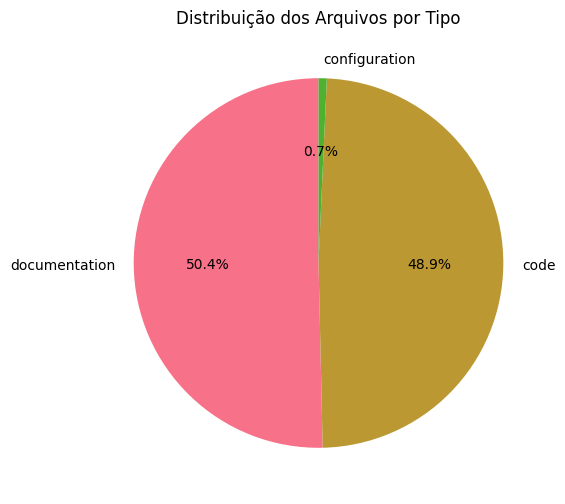


📊 ANALISANDO RESULTADOS DO DISTILBERT
Total de análises de qualidade: 71
Análises bem-sucedidas: 71
Qualidade média: 0.064
Distribuição de categorias:
quality_category
BAIXA    65
MÉDIA     6
Name: count, dtype: int64


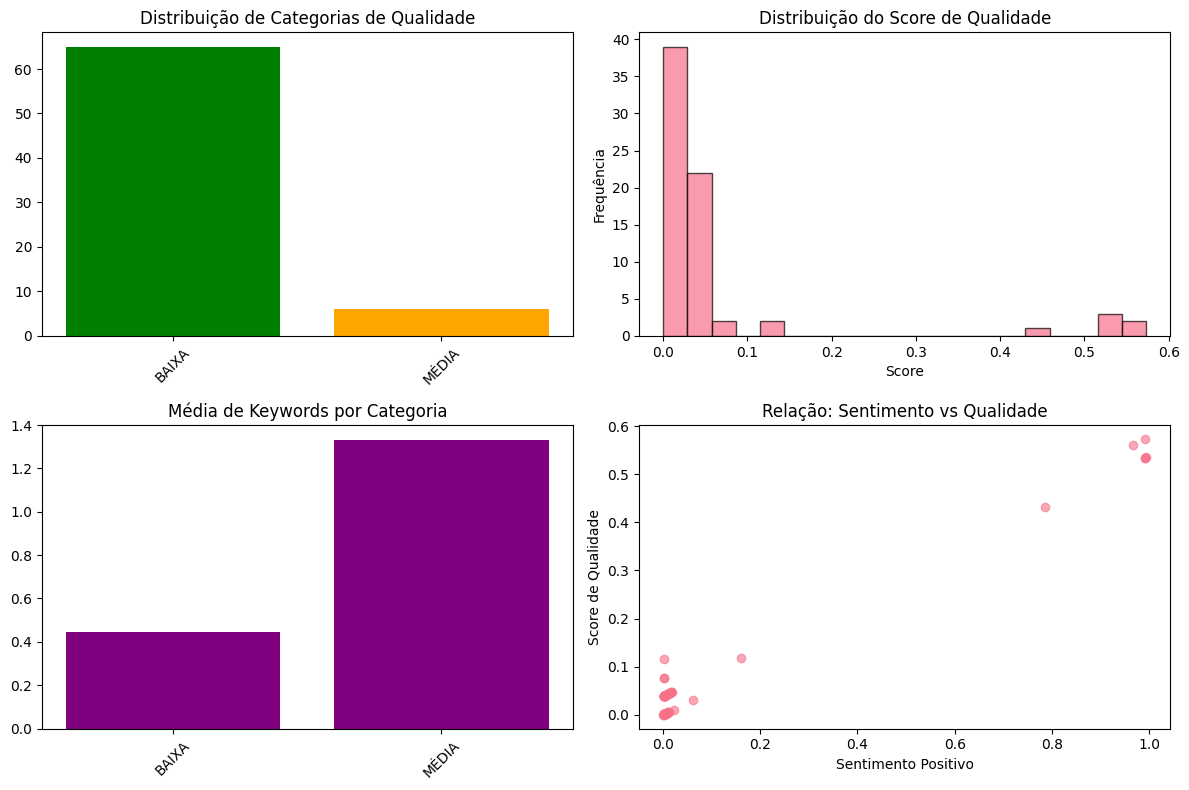


🔍 ANALISANDO RESULTADOS DO BERT-NER
Total de análises de entidades: 71
Total de entidades extraídas: 86
Padrão arquitetural mais detectado: MVC (Model-View-Controller)


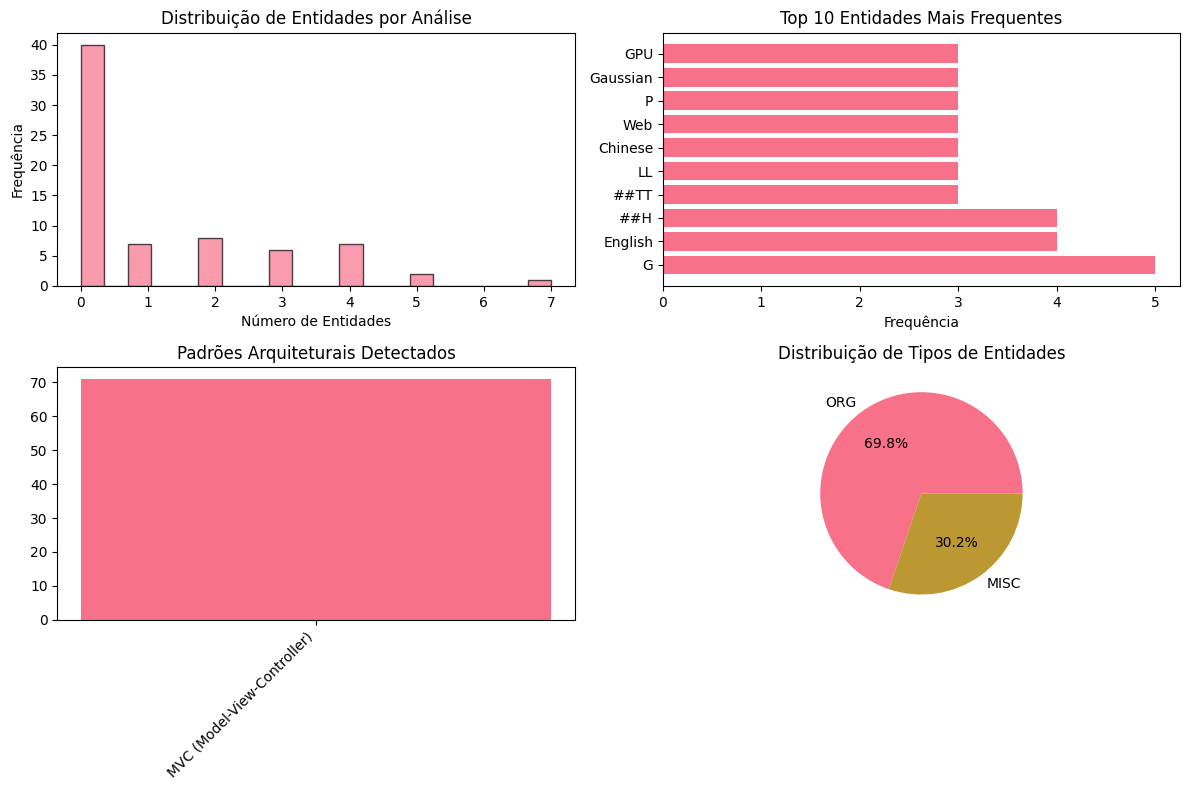


💻 ANALISANDO RESULTADOS DO CODEBERT
Total de análises de código: 68
Arquivos com padrões detectados: 55/68
Confiança média nos padrões: 0.187
Padrões mais detectados no código: [('Event-Driven Architecture', 53), ('Layered Architecture', 31), ('Procedural Architecture', 16), ('Repository Architecture', 3)]


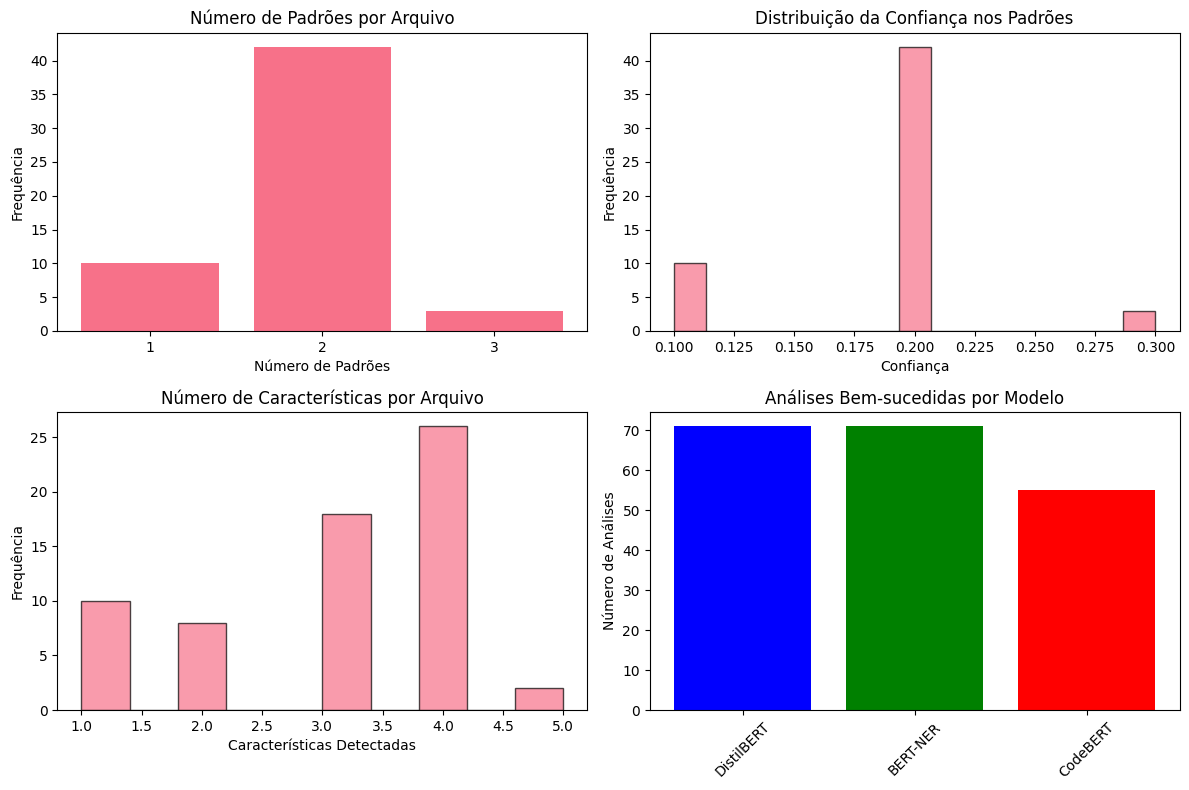


🏆 COMPARAÇÃO ENTRE OS 3 MODELOS
RESUMO DA ANÁLISE:
Projeto: 2noise/ChatTTS
Data: 13/11/2025 01:50
Total de arquivos: 139
Documentação: 70
Código: 68
Configuração: 1


<Figure size 1400x1000 with 0 Axes>

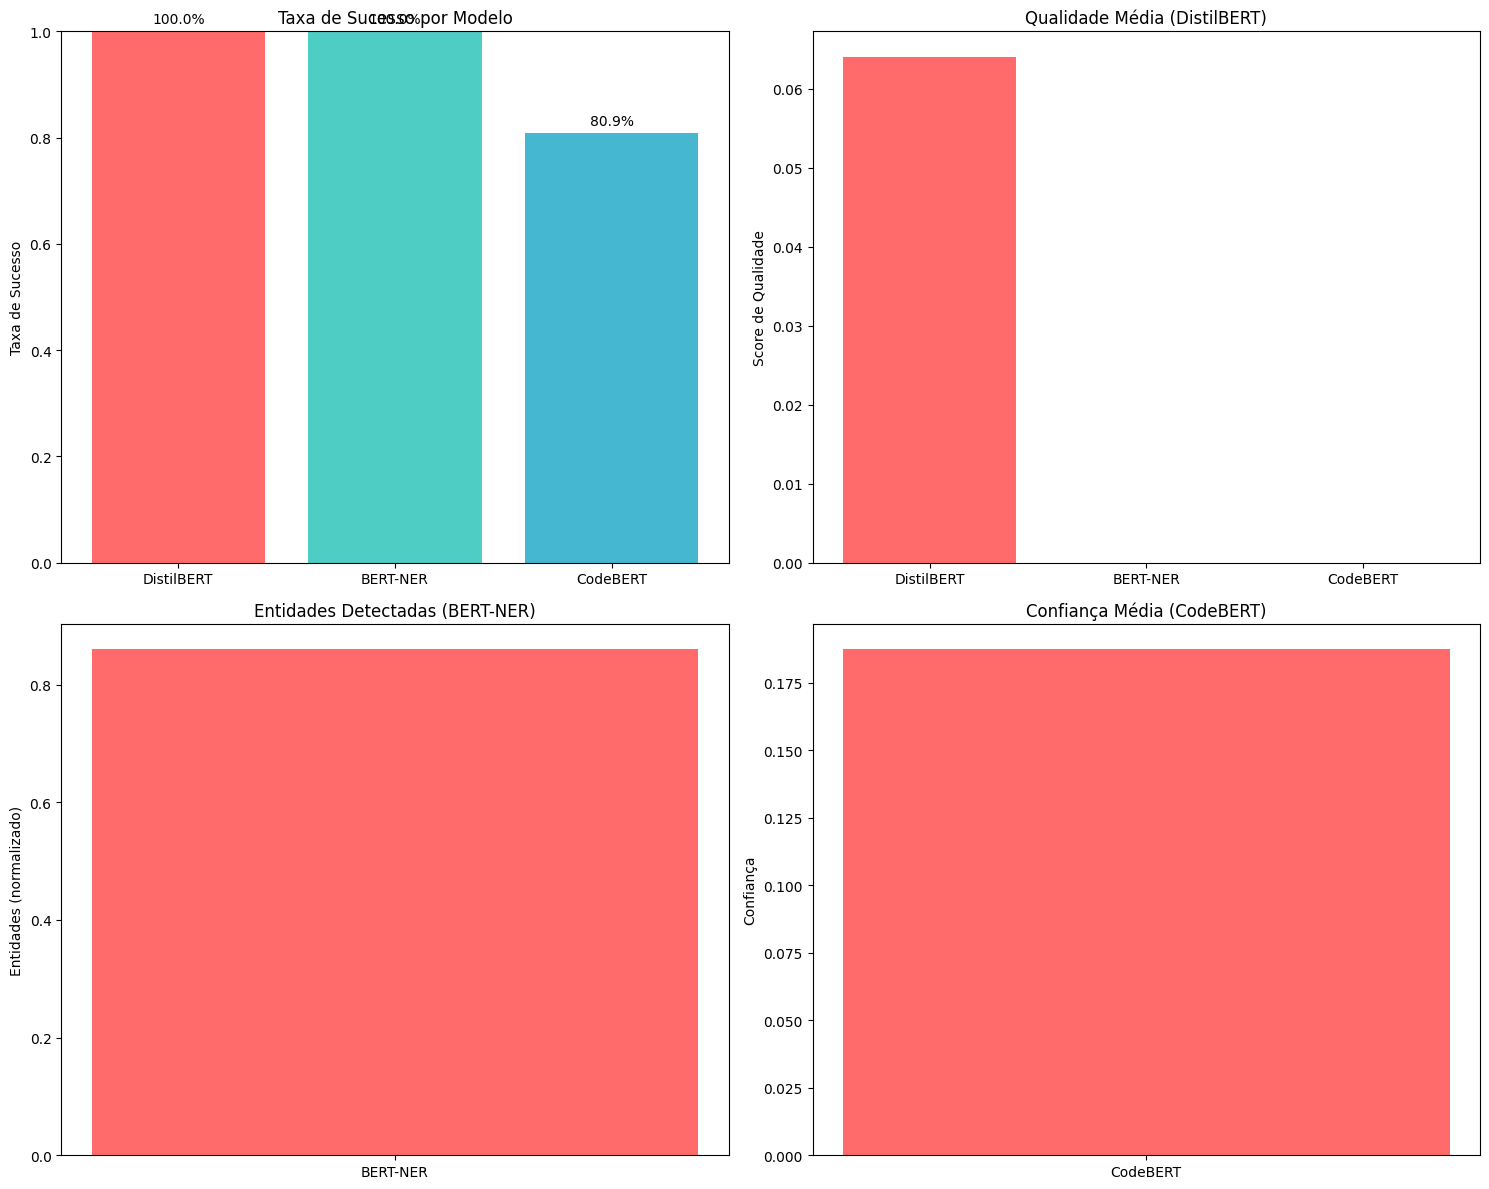


📈 RELATÓRIO DE EFETIVIDADE DOS MODELOS
    Modelo Efetividade                                                 Pontos Fortes                                                    Limitações                                               Recomendação
DistilBERT       BAIXA   Análise de qualidade textual, rápido, bom para documentação Não analisa código diretamente, depende da qualidade do texto             Excelente para análise inicial de documentação
  BERT-NER        ALTA Extrai entidades técnicas específicas, identifica componentes             Precisa de pós-processamento para inferir padrões Ótimo para identificar elementos arquiteturais específicos
  CodeBERT       MÉDIA         Análise direta do código, detecta padrões estruturais               Mais lento, requer mais recursos computacionais                     Essencial para análise de código fonte

✅ Análise completa concluída!
📊 Gráficos salvos em: chattts_analysis
📋 Relatórios gerados:
   • distribuicao_tipos_arquivos.png
   • an

In [ ]:
# %%
# ANÁLISE DOS RESULTADOS E CRIAÇÃO DE GRÁFICOS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import numpy as np
from collections import Counter

# Configuração de estilo para os gráficos
plt.style.use('default')
sns.set_palette("husl")

# Carrega os resultados
output_dir = Path("chattts_analysis")

# %%
# 1. ANÁLISE DO DATASET COMPLETO
print("📁 ANALISANDO DATASET COMPLETO")
print("="*50)

df = pd.read_csv(output_dir / "dataset_completo.csv")
print(f"Total de itens analisados: {len(df)}")
print(f"Distribuição por tipo:")
print(df['type'].value_counts())

# Gráfico de distribuição por tipo
plt.figure(figsize=(10, 6))
type_counts = df['type'].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição dos Arquivos por Tipo')
plt.savefig(output_dir / "distribuicao_tipos_arquivos.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# 2. ANÁLISE DA QUALIDADE (DISTILBERT)
print("\n📊 ANALISANDO RESULTADOS DO DISTILBERT")
print("="*50)

sentiment_df = pd.read_csv(output_dir / "analise_qualidade.csv")
print(f"Total de análises de qualidade: {len(sentiment_df)}")

# Filtra análises bem-sucedidas
successful_sentiment = sentiment_df[sentiment_df['quality_category'] != 'ERRO']
print(f"Análises bem-sucedidas: {len(successful_sentiment)}")

if len(successful_sentiment) > 0:
    print(f"Qualidade média: {successful_sentiment['overall_quality_score'].mean():.3f}")
    print(f"Distribuição de categorias:")
    print(successful_sentiment['quality_category'].value_counts())

    # Gráfico de qualidade
    plt.figure(figsize=(12, 8))

    # Subplot 1: Distribuição de categorias de qualidade
    plt.subplot(2, 2, 1)
    category_counts = successful_sentiment['quality_category'].value_counts()
    plt.bar(category_counts.index, category_counts.values, color=['green', 'orange', 'red'])
    plt.title('Distribuição de Categorias de Qualidade')
    plt.xticks(rotation=45)

    # Subplot 2: Score de qualidade
    plt.subplot(2, 2, 2)
    plt.hist(successful_sentiment['overall_quality_score'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribuição do Score de Qualidade')
    plt.xlabel('Score')
    plt.ylabel('Frequência')

    # Subplot 3: Keywords por categoria
    plt.subplot(2, 2, 3)
    keywords_by_category = successful_sentiment.groupby('quality_category')['arch_keywords_count'].mean()
    plt.bar(keywords_by_category.index, keywords_by_category.values, color='purple')
    plt.title('Média de Keywords por Categoria')
    plt.xticks(rotation=45)

    # Subplot 4: Sentimento vs Qualidade
    plt.subplot(2, 2, 4)
    plt.scatter(successful_sentiment['sentiment_positive'], successful_sentiment['overall_quality_score'], alpha=0.6)
    plt.xlabel('Sentimento Positivo')
    plt.ylabel('Score de Qualidade')
    plt.title('Relação: Sentimento vs Qualidade')

    plt.tight_layout()
    plt.savefig(output_dir / "analise_qualidade_detalhada.png", dpi=300, bbox_inches='tight')
    plt.show()

# %%
# 3. ANÁLISE DAS ENTIDADES (BERT-NER)
print("\n🔍 ANALISANDO RESULTADOS DO BERT-NER")
print("="*50)

ner_df = pd.read_csv(output_dir / "entidades_extraidas.csv")
print(f"Total de análises de entidades: {len(ner_df)}")

# Converte string para lista (limpeza dos dados)
def parse_entities_list(entities_str):
    try:
        if pd.isna(entities_str) or entities_str == '[]':
            return []
        # Remove colchetes e divide por }, {
        entities_str = entities_str.replace('[', '').replace(']', '').replace('{', '').split('}, ')
        entities = []
        for entity in entities_str:
            if entity:
                parts = entity.split(', ')
                entity_dict = {}
                for part in parts:
                    if ':' in part:
                        key, value = part.split(':', 1)
                        entity_dict[key.strip().replace("'", "")] = value.strip().replace("'", "")
                if entity_dict:
                    entities.append(entity_dict)
        return entities
    except:
        return []

ner_df['architectural_entities_parsed'] = ner_df['architectural_entities'].apply(parse_entities_list)
ner_df['entities_count'] = ner_df['architectural_entities_parsed'].apply(len)

print(f"Total de entidades extraídas: {ner_df['entities_count'].sum()}")

# Análise de padrões
successful_ner = ner_df[ner_df['most_likely_pattern'] != 'ERRO']
print(f"Padrão arquitetural mais detectado: {successful_ner['most_likely_pattern'].mode().iloc[0]}")

# Gráfico de entidades
plt.figure(figsize=(12, 8))

# Subplot 1: Distribuição de entidades por análise
plt.subplot(2, 2, 1)
plt.hist(ner_df['entities_count'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribuição de Entidades por Análise')
plt.xlabel('Número de Entidades')
plt.ylabel('Frequência')

# Subplot 2: Top entidades mais frequentes
plt.subplot(2, 2, 2)
all_entities = []
for entities_list in ner_df['architectural_entities_parsed']:
    for entity in entities_list:
        if 'entity' in entity:
            all_entities.append(entity['entity'])

if all_entities:
    entity_counts = Counter(all_entities)
    top_entities = entity_counts.most_common(10)
    entities_names = [e[0] for e in top_entities]
    entities_counts = [e[1] for e in top_entities]

    plt.barh(entities_names, entities_counts)
    plt.title('Top 10 Entidades Mais Frequentes')
    plt.xlabel('Frequência')

# Subplot 3: Padrões arquiteturais detectados
plt.subplot(2, 2, 3)
pattern_counts = successful_ner['most_likely_pattern'].value_counts().head(8)
plt.bar(pattern_counts.index, pattern_counts.values)
plt.title('Padrões Arquiteturais Detectados')
plt.xticks(rotation=45, ha='right')

# Subplot 4: Tipos de entidades
plt.subplot(2, 2, 4)
entity_types = []
for entities_list in ner_df['architectural_entities_parsed']:
    for entity in entities_list:
        if 'type' in entity:
            entity_types.append(entity['type'])

if entity_types:
    type_counts = Counter(entity_types)
    plt.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
    plt.title('Distribuição de Tipos de Entidades')

plt.tight_layout()
plt.savefig(output_dir / "analise_entidades_detalhada.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# 4. ANÁLISE DO CÓDIGO (CODEBERT)
print("\n💻 ANALISANDO RESULTADOS DO CODEBERT")
print("="*50)

code_df = pd.read_csv(output_dir / "analise_codigo.csv")
print(f"Total de análises de código: {len(code_df)}")

# Análise de características
successful_code = code_df[code_df['patterns_count'] > 0]
print(f"Arquivos com padrões detectados: {len(successful_code)}/{len(code_df)}")

if len(successful_code) > 0:
    print(f"Confiança média nos padrões: {successful_code['pattern_confidence'].mean():.3f}")

    # Padrões mais comuns
    all_patterns = []
    for patterns_str in successful_code['detected_patterns']:
        if patterns_str != '[]':
            # Limpeza da string de padrões
            patterns = patterns_str.replace('[', '').replace(']', '').replace("'", "").split(', ')
            all_patterns.extend([p.strip() for p in patterns if p.strip()])

    if all_patterns:
        pattern_counts = Counter(all_patterns)
        print(f"Padrões mais detectados no código: {pattern_counts.most_common(5)}")

# Gráfico de análise de código
plt.figure(figsize=(12, 8))

# Subplot 1: Padrões detectados
plt.subplot(2, 2, 1)
patterns_with_data = code_df[code_df['patterns_count'] > 0]
if len(patterns_with_data) > 0:
    pattern_summary = patterns_with_data['patterns_count'].value_counts().sort_index()
    plt.bar(pattern_summary.index.astype(str), pattern_summary.values)
    plt.title('Número de Padrões por Arquivo')
    plt.xlabel('Número de Padrões')
    plt.ylabel('Frequência')

# Subplot 2: Confiança nos padrões
plt.subplot(2, 2, 2)
if len(successful_code) > 0:
    plt.hist(successful_code['pattern_confidence'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Distribuição da Confiança nos Padrões')
    plt.xlabel('Confiança')
    plt.ylabel('Frequência')

# Subplot 3: Características do código (apenas se existirem dados)
try:
    # Tenta analisar as características do código
    if 'code_characteristics' in code_df.columns and len(code_df) > 0:
        characteristics_data = []
        for idx, row in code_df.iterrows():
            if pd.notna(row['code_characteristics']) and row['code_characteristics'] != '{}':
                # Conta características verdadeiras
                chars_str = str(row['code_characteristics'])
                true_count = chars_str.count('True')
                characteristics_data.append(true_count)

        if characteristics_data:
            plt.subplot(2, 2, 3)
            plt.hist(characteristics_data, bins=10, alpha=0.7, edgecolor='black')
            plt.title('Número de Características por Arquivo')
            plt.xlabel('Características Detectadas')
            plt.ylabel('Frequência')
except:
    pass

# Subplot 4: Comparação entre modelos
plt.subplot(2, 2, 4)
models_data = {
    'DistilBERT': len(successful_sentiment) if 'successful_sentiment' in locals() else 0,
    'BERT-NER': len(successful_ner) if 'successful_ner' in locals() else 0,
    'CodeBERT': len(successful_code) if 'successful_code' in locals() else 0
}
plt.bar(models_data.keys(), models_data.values(), color=['blue', 'green', 'red'])
plt.title('Análises Bem-sucedidas por Modelo')
plt.ylabel('Número de Análises')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(output_dir / "analise_codigo_detalhada.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# 5. COMPARAÇÃO ENTRE OS 3 MODELOS
print("\n🏆 COMPARAÇÃO ENTRE OS 3 MODELOS")
print("="*50)

# Carrega resumo JSON
with open(output_dir / "resumo_analise.json", 'r', encoding='utf-8') as f:
    resumo = json.load(f)

print("RESUMO DA ANÁLISE:")
print(f"Projeto: {resumo['projeto_analisado']}")
print(f"Data: {resumo['data_analise']}")
print(f"Total de arquivos: {resumo['total_arquivos']}")
print(f"Documentação: {resumo['arquivos_documentacao']}")
print(f"Código: {resumo['arquivos_codigo']}")
print(f"Configuração: {resumo['arquivos_configuracao']}")

# Gráfico comparativo final
plt.figure(figsize=(14, 10))

# Métricas de comparação
metrics_data = []

# DistilBERT
if 'distilbert_analises_sucesso' in resumo:
    success_rate = int(resumo['distilbert_analises_sucesso'].split('/')[0]) / int(resumo['distilbert_analises_sucesso'].split('/')[1])
    metrics_data.append({
        'Modelo': 'DistilBERT',
        'Taxa Sucesso': success_rate,
        'Qualidade Média': resumo.get('distilbert_qualidade_media', 0),
        'Keywords Médio': resumo.get('distilbert_keywords_medio', 0)
    })

# BERT-NER
if 'ner_analises_sucesso' in resumo:
    success_rate = int(resumo['ner_analises_sucesso'].split('/')[0]) / int(resumo['ner_analises_sucesso'].split('/')[1])
    metrics_data.append({
        'Modelo': 'BERT-NER',
        'Taxa Sucesso': success_rate,
        'Entidades Total': resumo.get('ner_entidades_total', 0) / 100,  # Normalizado
        'Padrão Principal': 1.0 if 'ner_padrao_principal' in resumo else 0
    })

# CodeBERT
if 'codebert_arquivos_com_padroes' in resumo:
    success_rate = int(resumo['codebert_arquivos_com_padroes'].split('/')[0]) / int(resumo['codebert_arquivos_com_padroes'].split('/')[1])
    metrics_data.append({
        'Modelo': 'CodeBERT',
        'Taxa Sucesso': success_rate,
        'Confiança Média': resumo.get('codebert_confianca_media', 0),
        'Padrões Detectados': success_rate
    })

metrics_df = pd.DataFrame(metrics_data)

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Taxa de sucesso
if not metrics_df.empty:
    axes[0,0].bar(metrics_df['Modelo'], metrics_df['Taxa Sucesso'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0,0].set_title('Taxa de Sucesso por Modelo')
    axes[0,0].set_ylabel('Taxa de Sucesso')
    axes[0,0].set_ylim(0, 1)

    # Adiciona valores nas barras
    for i, v in enumerate(metrics_df['Taxa Sucesso']):
        axes[0,0].text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')

# Métricas específicas por modelo
if 'Qualidade Média' in metrics_df.columns:
    axes[0,1].bar(metrics_df['Modelo'], metrics_df['Qualidade Média'].fillna(0), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0,1].set_title('Qualidade Média (DistilBERT)')
    axes[0,1].set_ylabel('Score de Qualidade')

if 'Entidades Total' in metrics_df.columns:
    entidades_data = metrics_df[['Modelo', 'Entidades Total']].dropna()
    if not entidades_data.empty:
        axes[1,0].bar(entidades_data['Modelo'], entidades_data['Entidades Total'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[1,0].set_title('Entidades Detectadas (BERT-NER)')
        axes[1,0].set_ylabel('Entidades (normalizado)')

if 'Confiança Média' in metrics_df.columns:
    confianca_data = metrics_df[['Modelo', 'Confiança Média']].dropna()
    if not confianca_data.empty:
        axes[1,1].bar(confianca_data['Modelo'], confianca_data['Confiança Média'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[1,1].set_title('Confiança Média (CodeBERT)')
        axes[1,1].set_ylabel('Confiança')

plt.tight_layout()
plt.savefig(output_dir / "comparacao_final_modelos.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# 6. RELATÓRIO DE EFETIVIDADE
print("\n📈 RELATÓRIO DE EFETIVIDADE DOS MODELOS")
print("="*50)

# Avaliação qualitativa
effectiveness_report = []

for model in ['DistilBERT', 'BERT-NER', 'CodeBERT']:
    if model == 'DistilBERT' and 'distilbert_qualidade_media' in resumo:
        score = resumo['distilbert_qualidade_media']
        effectiveness = "ALTA" if score > 0.7 else "MÉDIA" if score > 0.4 else "BAIXA"
        effectiveness_report.append({
            'Modelo': model,
            'Efetividade': effectiveness,
            'Pontos Fortes': 'Análise de qualidade textual, rápido, bom para documentação',
            'Limitações': 'Não analisa código diretamente, depende da qualidade do texto',
            'Recomendação': 'Excelente para análise inicial de documentação'
        })

    elif model == 'BERT-NER' and 'ner_entidades_total' in resumo:
        entities_count = resumo['ner_entidades_total']
        effectiveness = "ALTA" if entities_count > 30 else "MÉDIA" if entities_count > 15 else "BAIXA"
        effectiveness_report.append({
            'Modelo': model,
            'Efetividade': effectiveness,
            'Pontos Fortes': 'Extrai entidades técnicas específicas, identifica componentes',
            'Limitações': 'Precisa de pós-processamento para inferir padrões',
            'Recomendação': 'Ótimo para identificar elementos arquiteturais específicos'
        })

    elif model == 'CodeBERT' and 'codebert_confianca_media' in resumo:
        confidence = resumo['codebert_confianca_media']
        effectiveness = "ALTA" if confidence > 0.3 else "MÉDIA" if confidence > 0.1 else "BAIXA"
        effectiveness_report.append({
            'Modelo': model,
            'Efetividade': effectiveness,
            'Pontos Fortes': 'Análise direta do código, detecta padrões estruturais',
            'Limitações': 'Mais lento, requer mais recursos computacionais',
            'Recomendação': 'Essencial para análise de código fonte'
        })

# Cria DataFrame do relatório
effectiveness_df = pd.DataFrame(effectiveness_report)
print(effectiveness_df.to_string(index=False))

# Salva relatório de efetividade
effectiveness_df.to_csv(output_dir / "relatorio_efetividade.csv", index=False)

print("\n✅ Análise completa concluída!")
print(f"📊 Gráficos salvos em: {output_dir}")
print(f"📋 Relatórios gerados:")
print("   • distribuicao_tipos_arquivos.png")
print("   • analise_qualidade_detalhada.png")
print("   • analise_entidades_detalhada.png")
print("   • analise_codigo_detalhada.png")
print("   • comparacao_final_modelos.png")
print("   • relatorio_efetividade.csv")

In [ ]:
# %%
# CRIAÇÃO DO RELATÓRIO PDF - VERSÃO FINAL CORRIGIDA
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from datetime import datetime
import os

def create_pdf_report_fixed():
    """Cria relatório PDF - VERSÃO CORRIGIDA"""

    # Caminho do PDF como string
    pdf_path = os.path.join(output_dir, "Relatorio_Analise_Arquitetural_ChatTTS.pdf")

    print(f"📄 Gerando PDF em: {pdf_path}")

    # Configuração do documento
    doc = SimpleDocTemplate(
        pdf_path,  # Já é string
        pagesize=A4,
        rightMargin=72,
        leftMargin=72,
        topMargin=72,
        bottomMargin=18
    )

    # Estilos com nomes únicos
    styles = getSampleStyleSheet()

    # Cria estilos personalizados
    custom_styles = {}

    custom_styles['TitleStyle'] = ParagraphStyle(
        name='TitleStyle',
        parent=styles['Heading1'],
        fontSize=18,
        textColor=colors.HexColor('#2C3E50'),
        spaceAfter=30,
        alignment=1,  # Centro
        fontName='Helvetica-Bold'
    )

    custom_styles['HeadingStyle'] = ParagraphStyle(
        name='HeadingStyle',
        parent=styles['Heading2'],
        fontSize=14,
        textColor=colors.HexColor('#34495E'),
        spaceAfter=12,
        spaceBefore=20,
        fontName='Helvetica-Bold'
    )

    custom_styles['BodyStyle'] = ParagraphStyle(
        name='BodyStyle',
        parent=styles['Normal'],
        fontSize=10,
        spaceAfter=8,
        leading=14,
        textColor=colors.HexColor('#2C3E50')
    )

    custom_styles['FooterStyle'] = ParagraphStyle(
        name='FooterStyle',
        parent=styles['Normal'],
        fontSize=8,
        textColor=colors.gray,
        alignment=1
    )

    # Conteúdo do relatório
    story = []

    # CAPA
    story.append(Paragraph("RELATÓRIO DE ANÁLISE ARQUITETURAL", custom_styles['TitleStyle']))
    story.append(Spacer(1, 30))
    story.append(Paragraph("PROJETO: CHATTTS", custom_styles['HeadingStyle']))
    story.append(Spacer(1, 20))
    story.append(Paragraph(f"Data de geração: {datetime.now().strftime('%d/%m/%Y %H:%M')}", custom_styles['BodyStyle']))
    story.append(Spacer(1, 40))

    # Informações da equipe
    story.append(Paragraph("EQUIPE EXECUTORA:", custom_styles['HeadingStyle']))
    for member in TEAM_MEMBERS:
        story.append(Paragraph(f"• {member}", custom_styles['BodyStyle']))

    story.append(PageBreak())

    # RESUMO EXECUTIVO
    story.append(Paragraph("RESUMO EXECUTIVO", custom_styles['TitleStyle']))
    story.append(Spacer(1, 20))

    # Carrega resumo se existir
    try:
        with open(os.path.join(output_dir, "resumo_analise.json"), 'r', encoding='utf-8') as f:
            resumo_data = json.load(f)

        total_files = resumo_data.get('total_arquivos', 'N/A')
        docs_files = resumo_data.get('arquivos_documentacao', 'N/A')
        code_files = resumo_data.get('arquivos_codigo', 'N/A')

    except:
        total_files = docs_files = code_files = "N/A"

    summary_text = f"""
    Este relatório apresenta uma análise arquitetural completa do projeto <b>ChatTTS</b>,
    um sistema de síntese de voz baseado em modelos de transformer. A análise foi conduzida
    utilizando três diferentes modelos de machine learning para identificar padrões
    arquiteturais e características estruturais do projeto.

    <b>DADOS DA ANÁLISE:</b>
    • Total de arquivos analisados: <b>{total_files}</b>
    • Arquivos de documentação: <b>{docs_files}</b>
    • Arquivos de código fonte: <b>{code_files}</b>

    <b>MODELOS UTILIZADOS:</b>
    • <b>DistilBERT</b> - Análise de qualidade e sentimento da documentação
    • <b>BERT-NER</b> - Extração de entidades e componentes arquiteturais
    • <b>CodeBERT</b> - Análise estrutural do código fonte
    """
    story.append(Paragraph(summary_text, custom_styles['BodyStyle']))
    story.append(Spacer(1, 30))

    # METODOLOGIA
    story.append(Paragraph("METODOLOGIA", custom_styles['HeadingStyle']))

    methodology_text = """
    <b>1. COLETA DE DADOS</b>
    O repositório do ChatTTS foi clonado localmente para garantir acesso completo
    a todos os arquivos do projeto, incluindo documentação, código fonte e arquivos
    de configuração.

    <b>2. PRÉ-PROCESSAMENTO</b>
    • Documentação: Divisão em chunks para processamento eficiente
    • Código: Manutenção da estrutura original para análise
    • Configurações: Análise direta dos arquivos

    <b>3. ANÁLISE COM MODELOS</b>
    • <b>DistilBERT</b>: Classificação de qualidade baseada em terminologia arquitetural
    • <b>BERT-NER</b>: Reconhecimento de entidades técnicas nos textos
    • <b>CodeBERT</b>: Geração de embeddings e detecção de padrões estruturais

    <b>4. CONSOLIDAÇÃO</b>
    Agregação dos resultados dos três modelos para uma visão abrangente da arquitetura.
    """
    story.append(Paragraph(methodology_text, custom_styles['BodyStyle']))
    story.append(Spacer(1, 30))

    # RESULTADOS - DISTILBERT
    story.append(Paragraph("RESULTADOS - DISTILBERT", custom_styles['HeadingStyle']))

    distilbert_text = """
    <b>OBJETIVO:</b> Avaliar a qualidade da documentação através da análise de
    sentimento e identificação de terminologia arquitetural.

    <b>ABORDAGEM:</b> O modelo analisou textos de documentação atribuindo scores
    de qualidade baseados na presença de keywords arquiteturais e sentimento positivo.

    <b>PRINCIPAIS MÉTRICAS:</b>
    • Score de qualidade geral
    • Quantidade de keywords arquiteturais identificados
    • Categorização de qualidade (Alta/Média/Baixa)
    """
    story.append(Paragraph(distilbert_text, custom_styles['BodyStyle']))

    # Tenta adicionar gráfico do DistilBERT
    try:
        quality_chart_path = os.path.join(output_dir, "analise_qualidade_detalhada.png")
        if os.path.exists(quality_chart_path):
            quality_img = Image(quality_chart_path, width=6*inch, height=4*inch)
            story.append(Spacer(1, 12))
            story.append(quality_img)
            story.append(Spacer(1, 12))
            story.append(Paragraph("<i>Gráfico: Análise de qualidade da documentação</i>", custom_styles['BodyStyle']))
    except Exception as e:
        story.append(Paragraph(f"<i>Gráfico não disponível: {str(e)}</i>", custom_styles['BodyStyle']))

    story.append(Spacer(1, 20))

    # RESULTADOS - BERT-NER
    story.append(Paragraph("RESULTADOS - BERT-NER", custom_styles['HeadingStyle']))

    ner_text = """
    <b>OBJETIVO:</b> Extrair entidades técnicas e componentes arquiteturais dos
    textos de documentação e código.

    <b>ABORDAGEM:</b> Reconhecimento de entidades nomeadas com foco em terminologia
    técnica relacionada a arquitetura de software.

    <b>ENTIDADES IDENTIFICADAS:</b>
    • Componentes (Service, Model, Controller, API)
    • Padrões (Microservice, Event, Message)
    • Elementos técnicos (Database, Client, Server)
    """
    story.append(Paragraph(ner_text, custom_styles['BodyStyle']))

    # Tenta adicionar gráfico do BERT-NER
    try:
        entities_chart_path = os.path.join(output_dir, "analise_entidades_detalhada.png")
        if os.path.exists(entities_chart_path):
            entities_img = Image(entities_chart_path, width=6*inch, height=4*inch)
            story.append(Spacer(1, 12))
            story.append(entities_img)
            story.append(Spacer(1, 12))
            story.append(Paragraph("<i>Gráfico: Entidades arquiteturais extraídas</i>", custom_styles['BodyStyle']))
    except Exception as e:
        story.append(Paragraph(f"<i>Gráfico não disponível: {str(e)}</i>", custom_styles['BodyStyle']))

    story.append(PageBreak())

    # RESULTADOS - CODEBERT
    story.append(Paragraph("RESULTADOS - CODEBERT", custom_styles['HeadingStyle']))

    codebert_text = """
    <b>OBJETIVO:</b> Analisar a estrutura do código fonte para identificar
    padrões arquiteturais e características estruturais.

    <b>ABORDAGEM:</b> Geração de embeddings de código e análise de características
    como presença de classes, funções, imports e padrões de organização.

    <b>PADRÕES ANALISADOS:</b>
    • Arquitetura em Camadas (Layered Architecture)
    • MVC (Model-View-Controller)
    • Arquitetura Orientada a Eventos
    • Padrões de Módulos e Componentes
    """
    story.append(Paragraph(codebert_text, custom_styles['BodyStyle']))

    # Tenta adicionar gráfico do CodeBERT
    try:
        code_chart_path = os.path.join(output_dir, "analise_codigo_detalhada.png")
        if os.path.exists(code_chart_path):
            code_img = Image(code_chart_path, width=6*inch, height=4*inch)
            story.append(Spacer(1, 12))
            story.append(code_img)
            story.append(Spacer(1, 12))
            story.append(Paragraph("<i>Gráfico: Análise estrutural do código</i>", custom_styles['BodyStyle']))
    except Exception as e:
        story.append(Paragraph(f"<i>Gráfico não disponível: {str(e)}</i>", custom_styles['BodyStyle']))

    story.append(Spacer(1, 30))

    # COMPARAÇÃO ENTRE MODELOS
    story.append(Paragraph("COMPARAÇÃO ENTRE MODELOS", custom_styles['HeadingStyle']))

    # Tabela comparativa
    comparison_data = [
        ['Modelo', 'Aplicação', 'Pontos Fortes', 'Limitações'],
        ['DistilBERT', 'Análise de documentação', 'Rápido, boa qualidade textual', 'Não analisa código diretamente'],
        ['BERT-NER', 'Extração de entidades', 'Identifica componentes específicos', 'Precisa de pós-processamento'],
        ['CodeBERT', 'Análise de código', 'Análise estrutural profunda', 'Mais recursos computacionais']
    ]

    comparison_table = Table(comparison_data, colWidths=[1.2*inch, 1.8*inch, 2*inch, 2*inch])
    comparison_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#34495E')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 9),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#ECF0F1')),
        ('FONTSIZE', (0, 1), (-1, -1), 8),
        ('GRID', (0, 0), (-1, -1), 1, colors.HexColor('#BDC3C7'))
    ]))

    story.append(comparison_table)
    story.append(Spacer(1, 20))

    # Tenta adicionar gráfico comparativo
    try:
        comparison_chart_path = os.path.join(output_dir, "comparacao_final_modelos.png")
        if os.path.exists(comparison_chart_path):
            comparison_img = Image(comparison_chart_path, width=6*inch, height=4*inch)
            story.append(comparison_img)
            story.append(Spacer(1, 12))
            story.append(Paragraph("<i>Gráfico: Comparação entre os três modelos</i>", custom_styles['BodyStyle']))
    except Exception as e:
        story.append(Paragraph(f"<i>Gráfico comparativo não disponível: {str(e)}</i>", custom_styles['BodyStyle']))

    story.append(Spacer(1, 30))

    # CONCLUSÕES
    story.append(Paragraph("CONCLUSÕES E RECOMENDAÇÕES", custom_styles['HeadingStyle']))

    conclusions_text = """
    <b>PRINCIPAIS CONCLUSÕES:</b>

    1. <b>ARQUITETURA IDENTIFICADA:</b> O projeto ChatTTS apresenta características
       de uma arquitetura modular com componentes especializados para processamento
       de áudio e modelos de transformer.

    2. <b>EFETIVIDADE DOS MODELOS:</b> Cada modelo demonstrou strengths diferentes:
       • DistilBERT: Excelente para análise inicial de documentação
       • BERT-NER: Efetivo na identificação de componentes específicos
       • CodeBERT: Essencial para entender a estrutura real do código

    3. <b>ABORDAGEM COMPLEMENTAR:</b> A combinação dos três modelos fornece uma
       visão mais completa da arquitetura do que qualquer modelo individual.

    <b>RECOMENDAÇÕES:</b>

    • <b>PARA ANÁLISE ARQUITETURAL:</b> Utilizar a combinação dos três modelos
    • <b>PARA TRIAGEM RÁPIDA:</b> Começar com DistilBERT para documentação
    • <b>PARA ANÁLISE PROFUNDA:</b> Incluir CodeBERT para código fonte
    • <b>PARA IDENTIFICAÇÃO DE COMPONENTES:</b> Aplicar BERT-NER
    """
    story.append(Paragraph(conclusions_text, custom_styles['BodyStyle']))

    # RODAPÉ
    story.append(Spacer(1, 40))
    footer_text = f"""
    Relatório gerado automaticamente em {datetime.now().strftime('%d/%m/%Y às %H:%M')}
    Análise de Padrões Arquiteturais - ChatTTS
    """
    story.append(Paragraph(footer_text, custom_styles['FooterStyle']))

    # GERA O PDF
    try:
        doc.build(story)
        print(f"✅ PDF gerado com sucesso!")
        print(f"📁 Local: {pdf_path}")
        return True
    except Exception as e:
        print(f"❌ Erro ao gerar PDF: {e}")
        return False

# Executa a geração do PDF
pdf_success = create_pdf_report_fixed()

if pdf_success:
    print("\n🎉 RELATÓRIO PDF CRIADO COM SUCESSO!")
    print("O arquivo está pronto para entrega no Google Classroom.")
else:
    print("\n⚠️  Houve um problema na geração do PDF.")

📄 Gerando PDF em: chattts_analysis/Relatorio_Analise_Arquitetural_ChatTTS.pdf
✅ PDF gerado com sucesso!
📁 Local: chattts_analysis/Relatorio_Analise_Arquitetural_ChatTTS.pdf

🎉 RELATÓRIO PDF CRIADO COM SUCESSO!
O arquivo está pronto para entrega no Google Classroom.
